# Transfer Learning with TensorFlow Part 1: Feature Extraction

**Leveraging a working model's existing architecture and learned patterns for our own problem.**

## Why use transfer learning?

* Can leverage an existing neural network architecture **proven to work** on problems similar to our own
* Can leverage a working network architecture which has **already learned patterns** on similar data to our down (often reults in a great results with less data)

In [1]:
!nvidia-smi

Tue May 25 23:48:11 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Downloading and becoming one with the data

In [2]:
# Get the data (10% of 10 food classes from Food101)
import zipfile

# Download data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2021-05-25 23:48:11--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 173.194.203.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   167MB/s    in 1.0s    

2021-05-25 23:48:13 (167 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
# How many images in each folder?
import os

# Walk through directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")

There are 2 directories and 0 images in '10_food_classes_10_percent'
There are 10 directories and 0 images in '10_food_classes_10_percent/train'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_ric

## Creating data loaders (preparing the data)

We'll use the `ImageDataGenerator` class to load in our images in batches

In [4]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images: ")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical")
print("Testing images: ")
test_data_10_percent = test_datagen.flow_from_directory(test_dir,
                                                        target_size=IMAGE_SHAPE,
                                                        batch_size=BATCH_SIZE,
                                                        class_mode="categorical")

Training images: 
Found 750 images belonging to 10 classes.
Testing images: 
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run while the model trains)

Callbacks are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks:
* Tracking experiments with `TensorBoard`
* Model checkpoint with the `ModelCheckPoint` callback
* Stopping a model from training (before it trains too long and overfits) with the `EarlyStopping` callback

In [5]:
# Create TensorBoard callb ack (functionized because we need to create a new one for each model)

import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

# Creating models using TensorFlow Hub

In [6]:
# Comparing TensorFlow Hub models
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"
eff_net_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [7]:
# Import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [8]:
# Let's make a create_model function to create a model from a URL
def create_model(model_url: str, num_classes=10):
  """
  Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.
  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in the output layer, should be equal to number of target classes, default 10
  Returns:
    An uncompiled Keras Sequential model with model_url as feature extractor layer and Dense output layer with num_classes output neurons
  """
  # Download the pretrained model and save it as a Keras layer - `Trainable` freeze the already learned patterns
  # IMAGE_SHAPE+(3,) is a little syntax hack that achieves the full shape of the images (224, 224, 3) - 3 being the color channels
  feature_extraction_layer = hub.KerasLayer(model_url,
                                           trainable=False,
                                           name="feature_extraction_layer",
                                           input_shape=IMAGE_SHAPE+(3,))
  
  # Create our own model
  model = tf.keras.Sequential([
    feature_extraction_layer,
    layers.Dense(num_classes, activation="softmax", name="output_layer")
  ])

  return model

### Creating ResNet TensorFlow Hub feature extraction model

In [9]:
# Create model
resnet_model = create_model(resnet_url)

In [10]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 2048)              23564800  
_________________________________________________________________
output_layer (Dense)         (None, 10)                20490     
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [11]:
# Compile model
resnet_model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(), metrics=["accuracy"])

In [12]:
history_1 = resnet_model.fit(test_data_10_percent,
                             epochs=5,
                             steps_per_epoch=len(train_data_10_percent),
                             validation_data=test_data_10_percent,
                             validation_steps=len(test_data_10_percent),
                             callbacks=create_tensorboard_callback("logs", "resnet_1"))

Saving TensorBoard log files to: logs/resnet_1/20210525-234826
Epoch 1/5
24/24 [==============================] - 51s 781ms/step - loss: 1.8070 - accuracy: 0.4149 - val_loss: 1.1235 - val_accuracy: 0.6408
Epoch 2/5
24/24 [==============================] - 16s 704ms/step - loss: 0.8739 - accuracy: 0.7422 - val_loss: 0.7272 - val_accuracy: 0.7724
Epoch 3/5
24/24 [==============================] - 16s 689ms/step - loss: 0.7086 - accuracy: 0.7708 - val_loss: 0.6390 - val_accuracy: 0.8016
Epoch 4/5
24/24 [==============================] - 15s 653ms/step - loss: 0.6116 - accuracy: 0.8162 - val_loss: 0.5331 - val_accuracy: 0.8320
Epoch 5/5
24/24 [==============================] - 15s 660ms/step - loss: 0.5087 - accuracy: 0.8451 - val_loss: 0.4672 - val_accuracy: 0.8544


This transfer learning feature extraction model outperformed every single one of the models previously constructed manually - on only 10% of the training data.

In [13]:
import matplotlib.pyplot as plt

# Let's create a function to plot our loss curves
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics

  Args:
    history: TensorFlow History object

  Returns:
    Plots of training/validation loss and accuracy metrics
  """
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]
  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  # Plot loss
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();

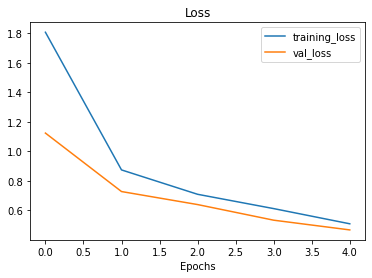

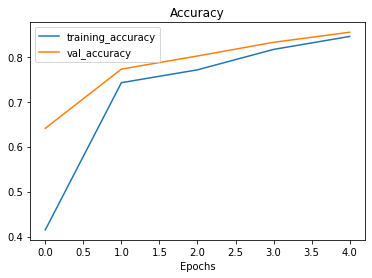

In [14]:
plot_loss_curves(history_1)

### Creating and testing EfficientNetB0 TensorFlow Hub Feature Extraction model

In [15]:
# Create EfficientNetB0 feature extraction model
eff_net_model = create_model(model_url=eff_net_url, num_classes=train_data_10_percent.num_classes)

# Compile
eff_net_model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(), metrics=["accuracy"])

# Train
history_2_eff_net = eff_net_model.fit(train_data_10_percent,
                                      epochs=5,
                                      steps_per_epoch=len(train_data_10_percent),
                                      validation_data=test_data_10_percent,
                                      validation_steps=len(test_data_10_percent),
                                      callbacks=[create_tensorboard_callback(dir_name="logs",
                                                                             experiment_name="eff_netb0")])

Saving TensorBoard log files to: logs/eff_netb0/20210525-235049
Epoch 1/5
24/24 [==============================] - 27s 826ms/step - loss: 1.8345 - accuracy: 0.4307 - val_loss: 1.2876 - val_accuracy: 0.7180
Epoch 2/5
24/24 [==============================] - 15s 664ms/step - loss: 1.0525 - accuracy: 0.7920 - val_loss: 0.8583 - val_accuracy: 0.8264
Epoch 3/5
24/24 [==============================] - 15s 661ms/step - loss: 0.7548 - accuracy: 0.8267 - val_loss: 0.6918 - val_accuracy: 0.8440
Epoch 4/5
24/24 [==============================] - 15s 664ms/step - loss: 0.6048 - accuracy: 0.8667 - val_loss: 0.6050 - val_accuracy: 0.8600
Epoch 5/5
24/24 [==============================] - 15s 658ms/step - loss: 0.5136 - accuracy: 0.8867 - val_loss: 0.5505 - val_accuracy: 0.8616


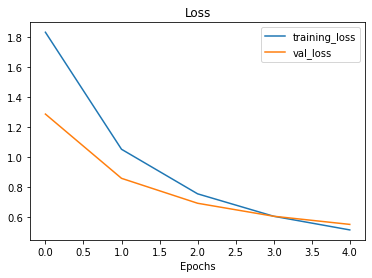

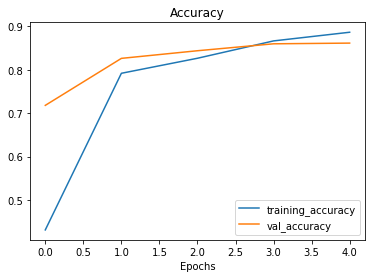

In [16]:
plot_loss_curves(history_2_eff_net)

### Different types of transfer learning
* **"As is" transfer learnng** - using an existing model with no changes whatsoever
* **"Feature extraction" transfer learning** - use the prelearned patterns of an existing model and adjust the output layer for your own problem
* **"Fine-tuning" transfer learning** - use the prelearned patterns of an existing model and "fine-tune" many or all of the underlying layers (inclduing new output layers)

In [17]:
# How many layers does our efficientnetb0 feature extractor have?
len(eff_net_model.layers[0].weights)

309

**WOWZA**

# TensorBoard
* A way to visually explore your machine learning models performance and internals
* host, track and share your machine learning experiments on TensorBoardDev

**WARNING**: When you upload things to TensorBoard.dev, your experiments are public. So if you're running private experiments, do **not** upload them to TensorBoard.dev

In [18]:
# Upload TensorBoard dev records
# !tensorboard dev upload --logdir ./logs \
  # --name "EfficientNetB0 vs. ResNet50V2" \
  # --description "please work" \
  # --one_shot

Tensorboard experiments are uploaded publicly here: https://tensorboard.dev/experiment/U9fmsnndQCeycrjQJrdcQA/

In [19]:
# Checkout what Tensorboard experiments you have
!tensorboard dev list

2021-05-25 23:52:26.439785: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0

***** TensorBoard Uploader *****

This will list all experiments that you've uploaded to
https://tensorboard.dev. TensorBoard.dev experiments are visible
to everyone. Do not upload sensitive data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A

In [20]:
# Delete an experiment
# !tensorboard dev delete --experiment_id {INSERT_EXPERIMENT ID}

In [25]:
saved_eff_net_model = eff_net_model.save("/content/drive/MyDrive/Colab Notebooks/eff_net_model")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/eff_net_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/eff_net_model/assets


In [24]:
loaded_model = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/eff_net_model")

In [26]:
loaded_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 1280)              4049564   
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________
